#1. Import Libraries


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Import dataset from Google Drive

In [3]:
df =pd.read_excel("/content/drive/MyDrive/MASA_Hack/Travel_Ins.xlsx")
df

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,M,63


In [4]:
#Rename the column to remove spaces
df.rename(columns={ 'Agency Type':'Type', 'Distribution Channel':'Channel', 'Product Name':'Product','Net Sales':'Net_Sales', 'Commision (in value)':'Commision'},inplace=True)

#3. EDA (Simple one, more details in PowerBi)

##Separate the column into numerical and categorical

In [5]:
##Separate the column into numerical and categorical 
numerical=['Duration','Net_Sales','Commision','Age']
categorical=['Agency','Type','Channel','Product','Claim','Destination','Gender']
df=df[numerical+categorical]

##Density and distribution plot for Numerical column

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

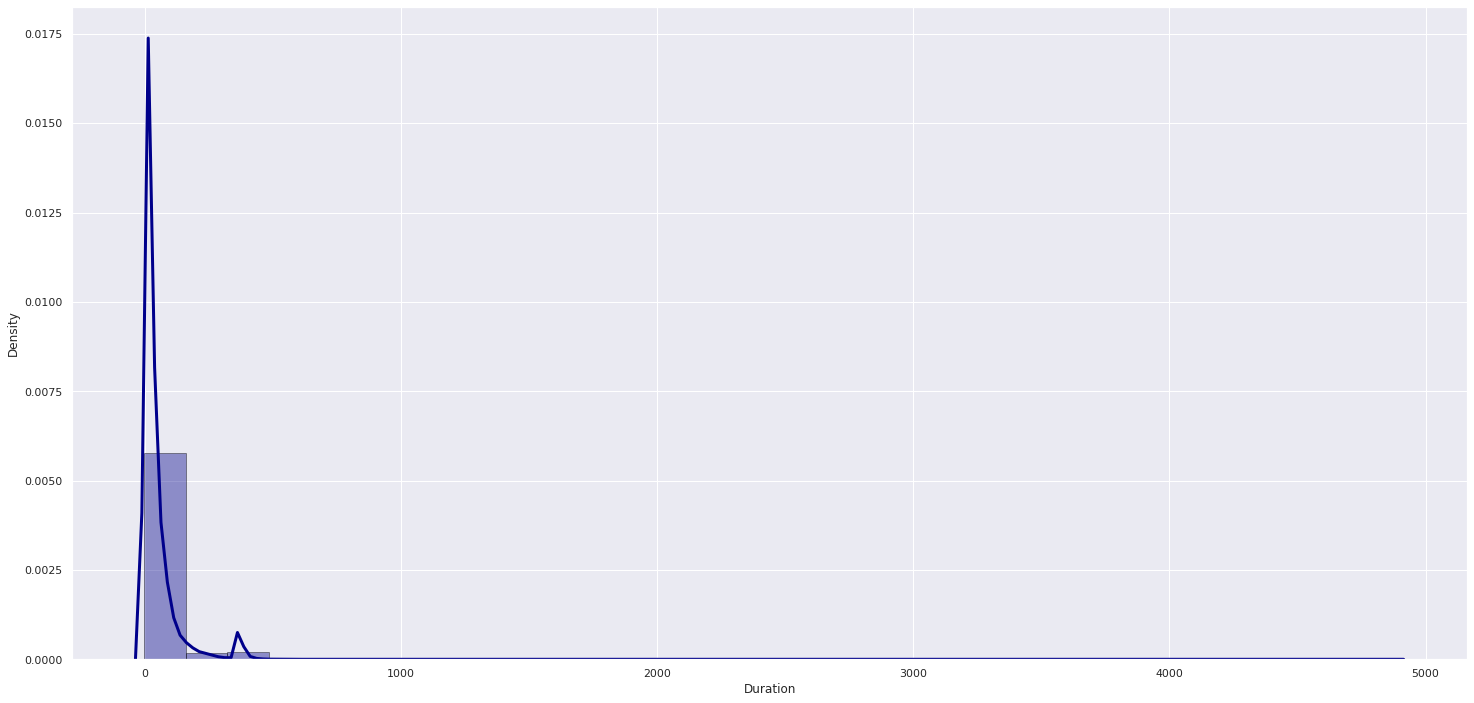

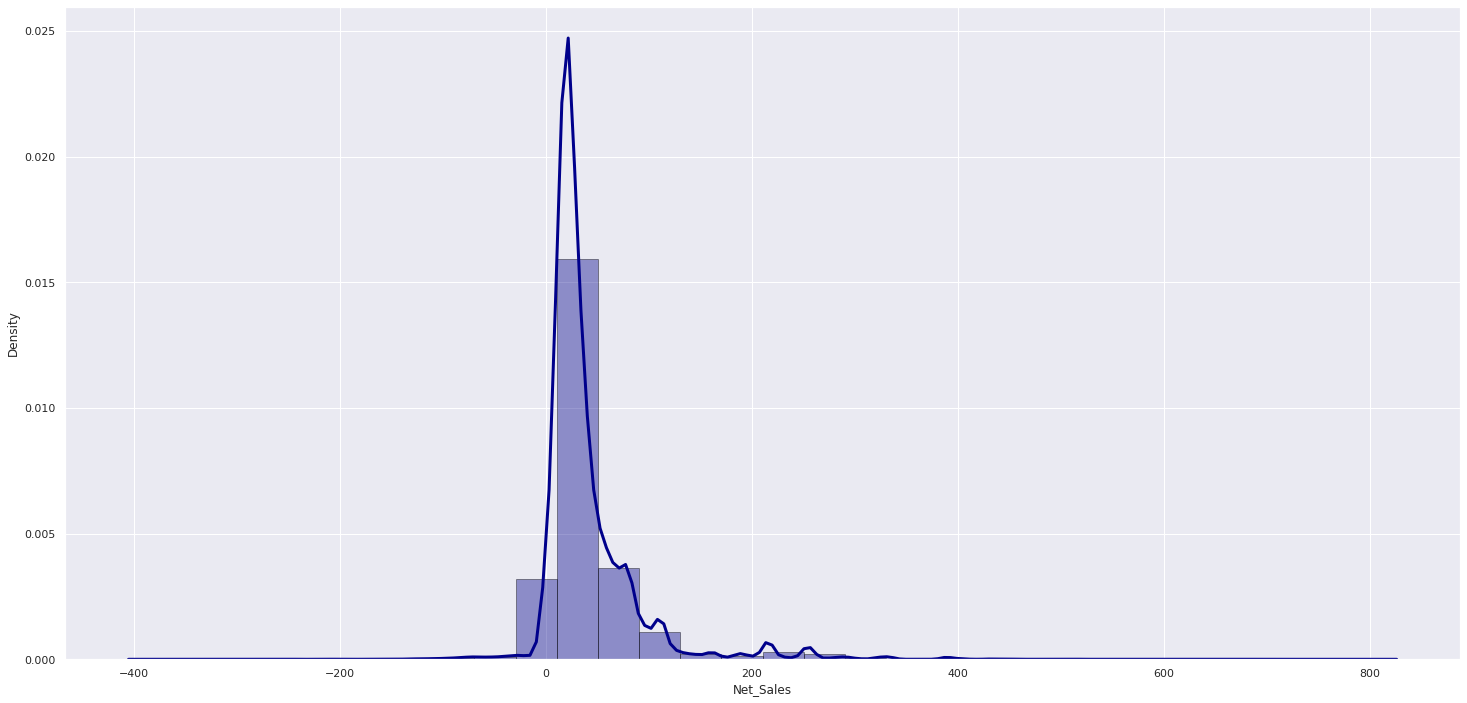

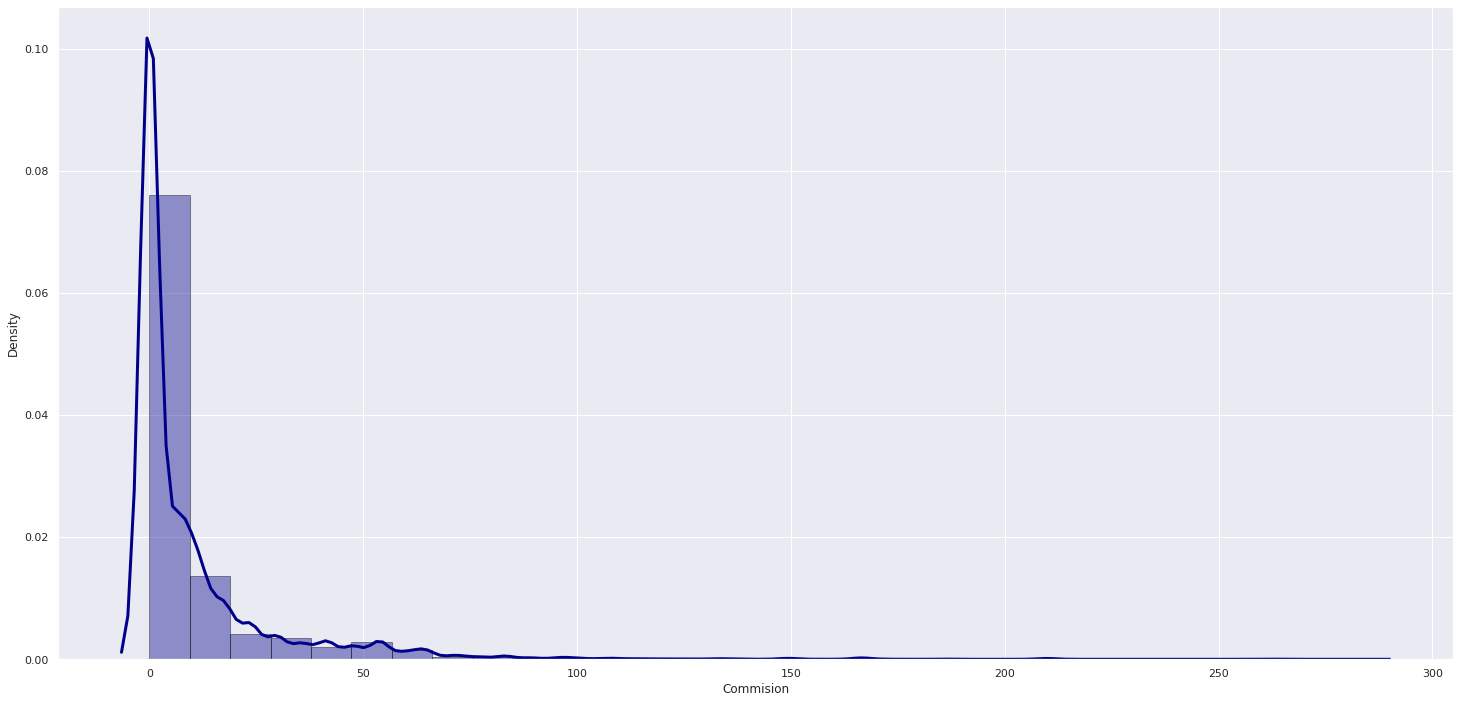

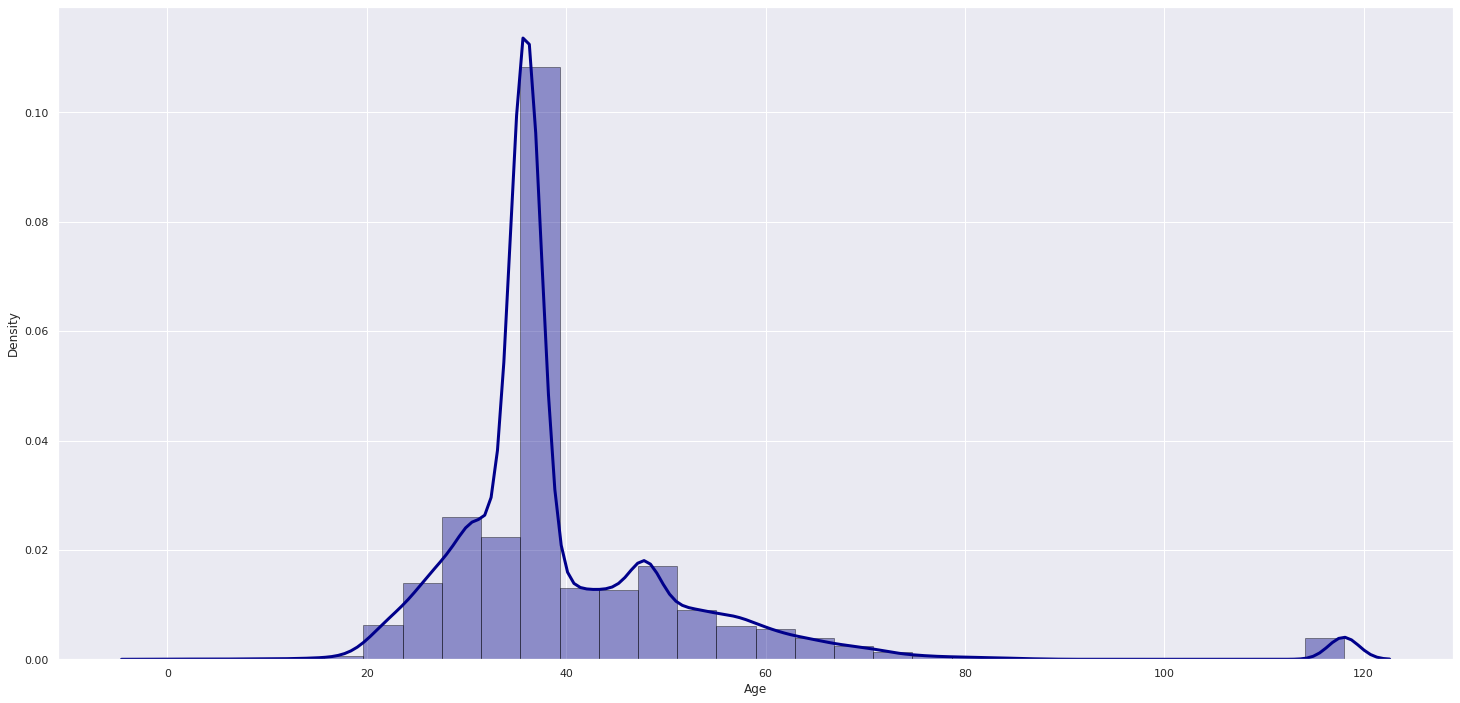

In [6]:
sns.set(rc={'figure.figsize':(25,12)})
for i in numerical:
    plt.figure()
    sns.distplot(df[i], hist=True, kde=True, 
                bins=30, color = 'darkblue', 
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 3})
  

##Pie Chart for categorical column

In [7]:
title=['Top 5 Agencies','Type of Agencies','Distribution Channel Used','Top 5 Products','Claim Success Rate','Top 5 Destination','Gender Comparison']
fig = plt.figure(figsize = (20, 10))
for i in range(len(categorical)):
    df_= df.groupby(by=[categorical[i]]).size().reset_index(name="counts")
    fig = px.pie(df_, values='counts',names=categorical[i],title=title[i])
    fig.show()


<Figure size 1440x720 with 0 Axes>

#4. Feature Selection

##Check the data type and non-null count for each column


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Duration     63326 non-null  int64  
 1   Net_Sales    63326 non-null  float64
 2   Commision    63326 non-null  float64
 3   Age          63326 non-null  int64  
 4   Agency       63326 non-null  object 
 5   Type         63326 non-null  object 
 6   Channel      63326 non-null  object 
 7   Product      63326 non-null  object 
 8   Claim        63326 non-null  object 
 9   Destination  63326 non-null  object 
 10  Gender       18219 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


##Drop gender column as there is too many missing values


In [9]:
df=df.drop(['Gender'], axis=1)
df

,Duration,Net_Sales,Commision,Age,Agency,Type,Channel,Product,Claim,Destination
0,186,-29.0,9.57,81,CBH,Travel Agency,Offline,Comprehensive Plan,No,MALAYSIA
1,186,-29.0,9.57,71,CBH,Travel Agency,Offline,Comprehensive Plan,No,MALAYSIA
2,65,-49.5,29.70,32,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,AUSTRALIA
3,60,-39.6,23.76,32,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,AUSTRALIA
4,79,-19.8,11.88,41,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,ITALY
...,...,...,...,...,...,...,...,...,...,...
63321,111,35.0,12.25,31,JZI,Airlines,Online,Basic Plan,No,JAPAN
63322,58,40.0,14.00,40,JZI,Airlines,Online,Basic Plan,No,CHINA
63323,2,18.0,6.30,57,JZI,Airlines,Online,Basic Plan,No,MALAYSIA
63324,3,18.0,6.30,63,JZI,Airlines,Online,Basic Plan,No,VIET NAM


##Check the descriptive statistic of the dataset

In [10]:
df.describe()

,Duration,Net_Sales,Commision,Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


##Use boxplot to further detect the outliers/abnormal data.

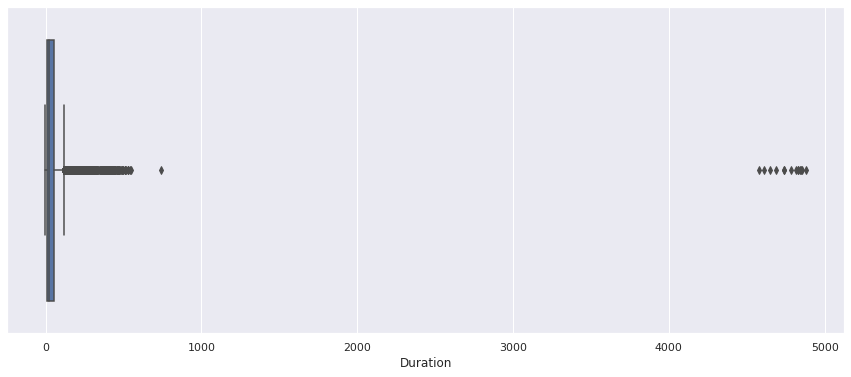

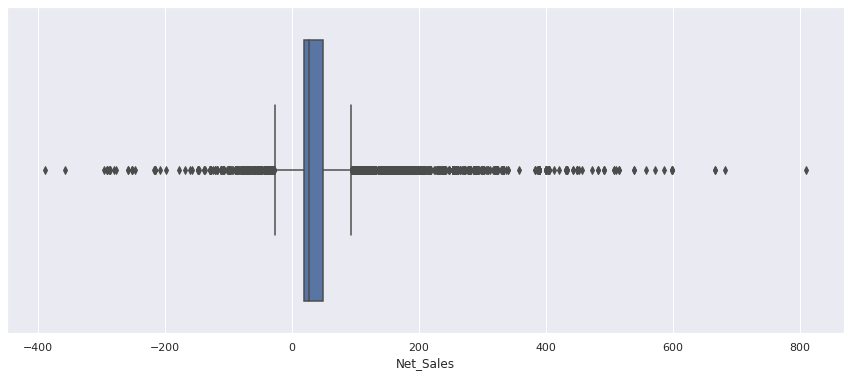

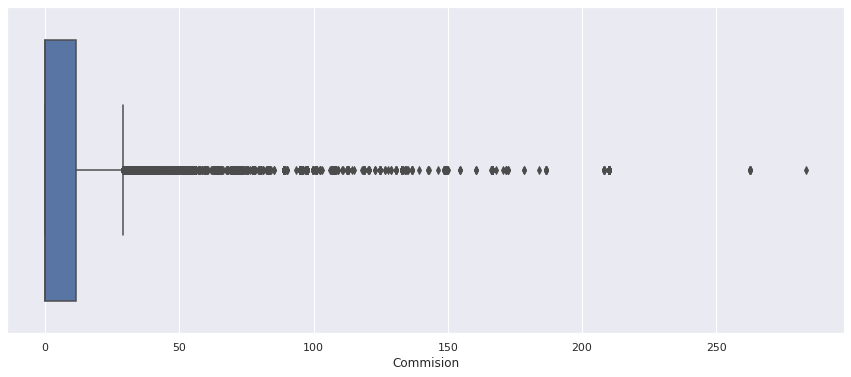

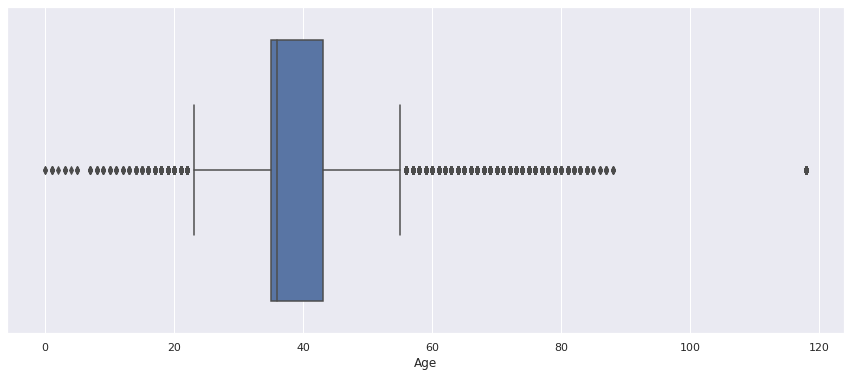

In [11]:
sns.set(rc={'figure.figsize':(15,6)})
for column in numerical:
    plt.figure()
    sns.boxplot(x=df[column])

##Abnormalies detected


*   **Age** equal to **118** is nearly impossible in real life
*   **Duration** of travel more than **4000** is no longer a travel

Drop the rows contain these abnormalies



In [12]:
list_1=df[(df['Age'] ==118)].index
df.drop(list_1, inplace=True)
list_2=df[(df['Duration'] >4000)].index
df.drop(list_2, inplace=True)

In [13]:
df.describe()

,Duration,Net_Sales,Commision,Age
count,62328.000000,62328.000000,62328.000000,62328.000000
mean,48.580333,40.569067,9.664149,38.736282
std,74.212078,48.885308,19.806663,10.097513
min,0.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,23.000000,26.000000,0.000000,36.000000
75%,53.000000,48.000000,10.500000,43.000000
max,740.000000,682.000000,262.760000,88.000000


## Label encoding the categorical columns

In [14]:
label_encoder1 = LabelEncoder()
df['Agency']= label_encoder1.fit_transform(df['Agency'])
  
label_encoder2 = LabelEncoder()
df['Type']= label_encoder2.fit_transform(df['Type'])

label_encoder3 = LabelEncoder()
df['Channel']= label_encoder3.fit_transform(df['Channel'])

label_encoder4 = LabelEncoder()
df['Product']= label_encoder4.fit_transform(df['Product'])

label_encoder5 = LabelEncoder()
df['Claim']= label_encoder5.fit_transform(df['Claim'])

label_encoder6 = LabelEncoder()
df['Destination']= label_encoder6.fit_transform(df['Destination'])

## Reindex the column so that 'Claim' (label) is the last column


In [15]:
column_names = ["Agency", "Type", "Channel","Product","Duration","Destination","Net_Sales","Commision","Age","Claim"]
df = df.reindex(columns=column_names)

In [16]:
df

,Agency,Type,Channel,Product,Duration,Destination,Net_Sales,Commision,Age,Claim
0,3,1,0,12,186,78,-29.0,9.57,81,0
1,3,1,0,12,186,78,-29.0,9.57,71,0
2,6,1,1,16,65,4,-49.5,29.70,32,0
3,6,1,1,16,60,4,-39.6,23.76,32,0
4,6,1,1,16,79,61,-19.8,11.88,41,0
...,...,...,...,...,...,...,...,...,...,...
63321,8,0,1,8,111,63,35.0,12.25,31,0
63322,8,0,1,8,58,26,40.0,14.00,40,0
63323,8,0,1,8,2,78,18.0,6.30,57,0
63324,8,0,1,8,3,143,18.0,6.30,63,0


## Check the correlation table to determine 
*    whether there is high collineartity within the predictive variables
*    whether all of the predictive variable collinear to the target variable

Keep the result, build a baseline model first, do feature selection if the perofrmance is not satisfying

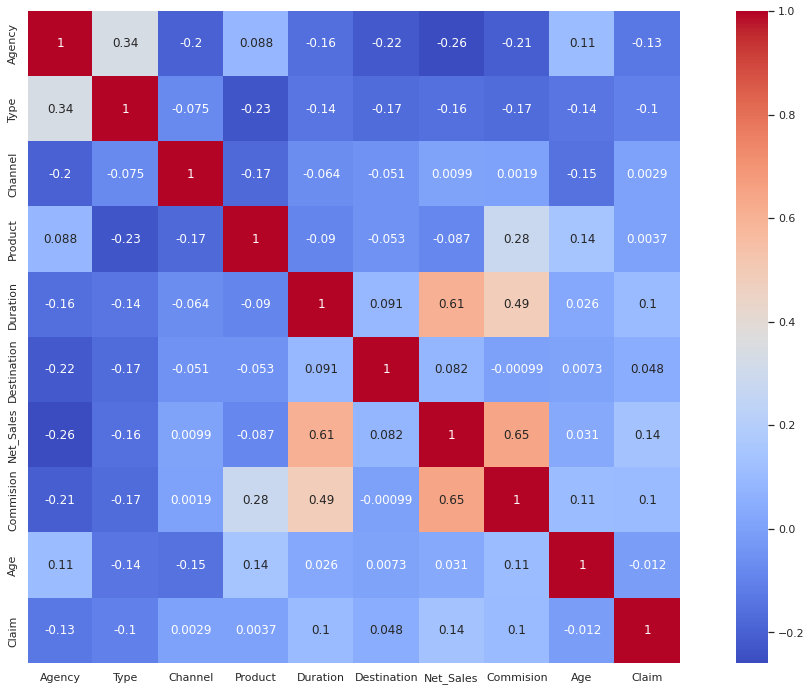

In [17]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), square=True,annot=True,cmap= 'coolwarm')

##Sepearting predictive variable and target variable into X and y respectively.



In [18]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

##Oversampling using SMOTE

In [19]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

##Combination of Oversampling + Undersampling Using SMOTE+ENN

In [20]:
smenn=SMOTEENN(random_state=42)
X_smenn,y_smenn=smenn.fit_resample(X,y)

##Split into train and test set

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train_sm,X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,test_size=0.2,random_state=42)
X_train_smenn,X_test_smenn,y_train_smenn,y_test_smenn = train_test_split(X_smenn,y_smenn,test_size=0.2,random_state=42)

##Standard Scale

In [22]:
sc1=StandardScaler()
X_train_ori=sc1.fit_transform(X_train)
X_test_ori=sc1.transform(X_test)

sc2=StandardScaler()
X_train_sm=sc2.fit_transform(X_train_sm)
X_test_sm=sc2.transform(X_test_sm)

sc3=StandardScaler()
X_train_smenn=sc3.fit_transform(X_train_smenn)
X_test_smenn=sc3.transform(X_test_smenn)

#Modelling & Evaluation


##Logistic regression

Accuracy = 0.9863
Recall = 0.0000
F1 score = 0.0000



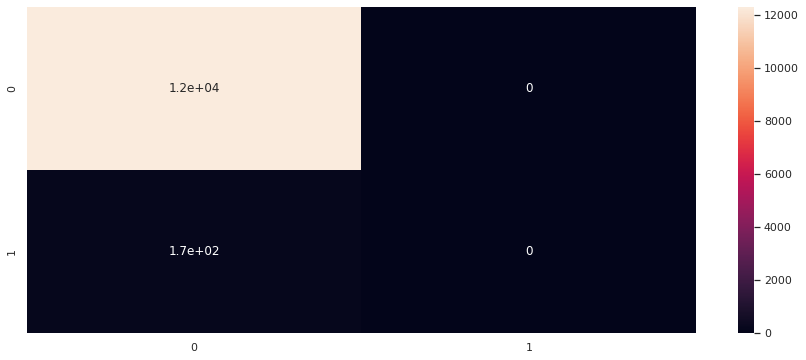

In [23]:
#Original dataset
LR=LogisticRegression(max_iter=200)
LR.fit(X_train_ori,y_train)
LR_pred_ori=LR.predict(X_test_ori)
LR_ori_accuracy=accuracy_score(y_test, LR_pred_ori)
LR_ori_recall=recall_score(y_test, LR_pred_ori)
LR_ori_f1=f1_score(y_test, LR_pred_ori)
print(f'Accuracy = {LR_ori_accuracy:.4f}\nRecall = {LR_ori_recall:.4f}\nF1 score = {LR_ori_f1:.4f}\n')
cm = confusion_matrix(y_test, LR_pred_ori)
sns.heatmap(cm, annot=True)

Accuracy = 0.7535
Recall = 0.6679
F1 score = 0.7274


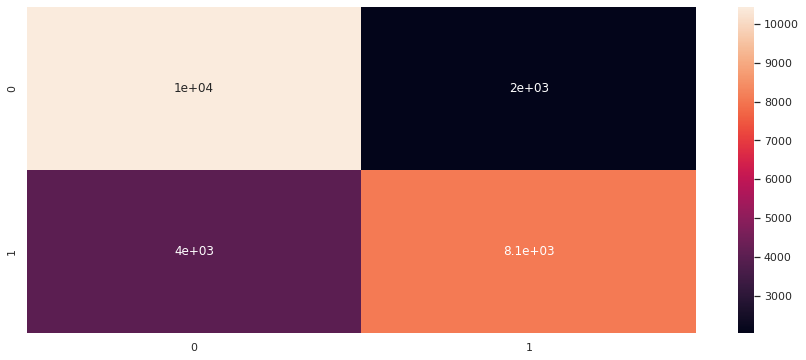

In [24]:
#SMOTE dataset
LR_sm=LogisticRegression()
LR_sm.fit(X_train_sm,y_train_sm)
LR_pred_sm=LR_sm.predict(X_test_sm)
LR_sm_accuracy=accuracy_score(y_test_sm, LR_pred_sm)
LR_sm_recall=recall_score(y_test_sm, LR_pred_sm)
LR_sm_f1=f1_score(y_test_sm, LR_pred_sm)
print(f'Accuracy = {LR_sm_accuracy:.4f}\nRecall = {LR_sm_recall:.4f}\nF1 score = {LR_sm_f1:.4f}')
cm = confusion_matrix(y_test_sm, LR_pred_sm)
sns.heatmap(cm, annot=True)

Accuracy = 0.7754
Recall = 0.6996
F1 score = 0.7621


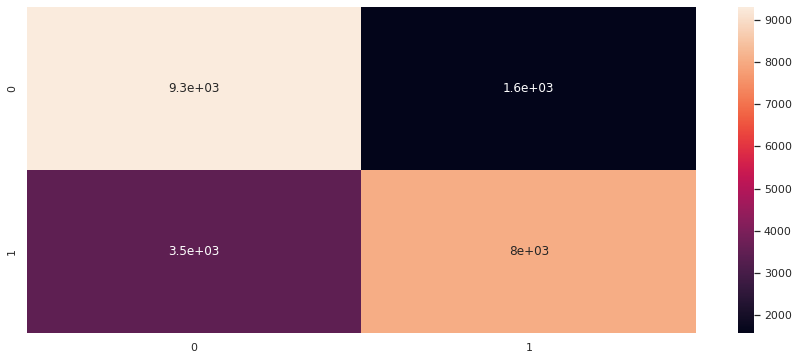

In [25]:
#SMOTE+ENN dataset
LR_smenn=LogisticRegression()
LR_smenn.fit(X_train_smenn,y_train_smenn)
LR_pred_smenn=LR_smenn.predict(X_test_smenn)
LR_smenn_accuracy=accuracy_score(y_test_smenn, LR_pred_smenn)
LR_smenn_recall=recall_score(y_test_smenn, LR_pred_smenn)
LR_smenn_f1=f1_score(y_test_smenn, LR_pred_smenn)
print(f'Accuracy = {LR_smenn_accuracy:.4f}\nRecall = {LR_smenn_recall:.4f}\nF1 score = {LR_smenn_f1:.4f}')
cm = confusion_matrix(y_test_smenn, LR_pred_smenn)
sns.heatmap(cm, annot=True)

In [57]:
#Collect Logistic Regression Result
LR_ori_result=[LR_ori_accuracy,LR_ori_recall,LR_ori_f1]
LR_sm_result=[LR_sm_accuracy,LR_sm_recall,LR_sm_f1]
LR_smenn_result=[LR_smenn_accuracy,LR_smenn_recall,LR_smenn_f1]

##Random Forest Classifier

Accuracy = 0.9837
Recall = 0.0117
F1 score = 0.0193


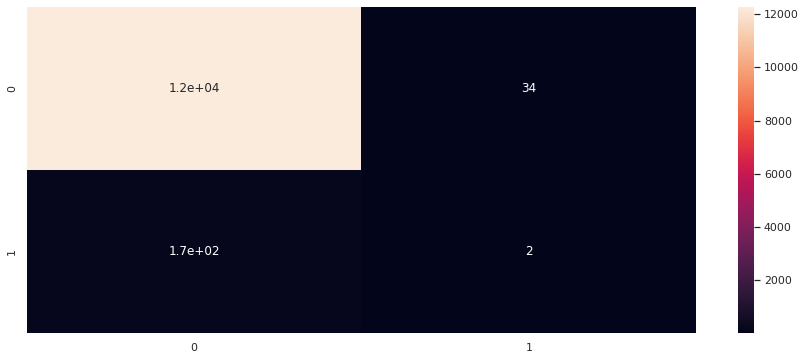

In [27]:
#Original dataset
RFC=RandomForestClassifier(random_state=42)
RFC.fit(X_train_ori,y_train)
RFC_pred_ori=RFC.predict(X_test_ori)
RFC_ori_accuracy=accuracy_score(y_test, RFC_pred_ori)
RFC_ori_recall=recall_score(y_test, RFC_pred_ori)
RFC_ori_f1=f1_score(y_test, RFC_pred_ori)
print(f'Accuracy = {RFC_ori_accuracy:.4f}\nRecall = {RFC_ori_recall:.4f}\nF1 score = {RFC_ori_f1:.4f}')
cm = confusion_matrix(y_test, RFC_pred_ori)
sns.heatmap(cm, annot=True)

Accuracy = 0.9803
Recall = 0.9820
F1 score = 0.9800


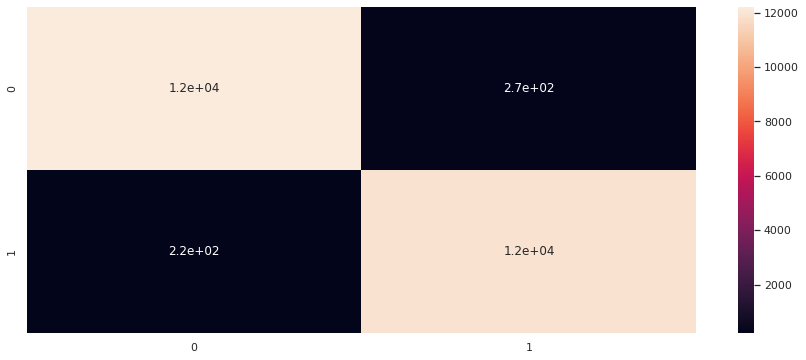

In [28]:
#SMOTE dataset
RFC_sm=RandomForestClassifier(random_state=42)
RFC_sm.fit(X_train_sm,y_train_sm)
RFC_pred_sm=RFC_sm.predict(X_test_sm)
RFC_sm_accuracy=accuracy_score(y_test_sm, RFC_pred_sm)
RFC_sm_recall=recall_score(y_test_sm, RFC_pred_sm)
RFC_sm_f1=f1_score(y_test_sm, RFC_pred_sm)
print(f'Accuracy = {RFC_sm_accuracy:.4f}\nRecall = {RFC_sm_recall:.4f}\nF1 score = {RFC_sm_f1:.4f}')
cm = confusion_matrix(y_test_sm, RFC_pred_sm)
sns.heatmap(cm, annot=True)

Accuracy = 0.9922
Recall = 0.9911
F1 score = 0.9924


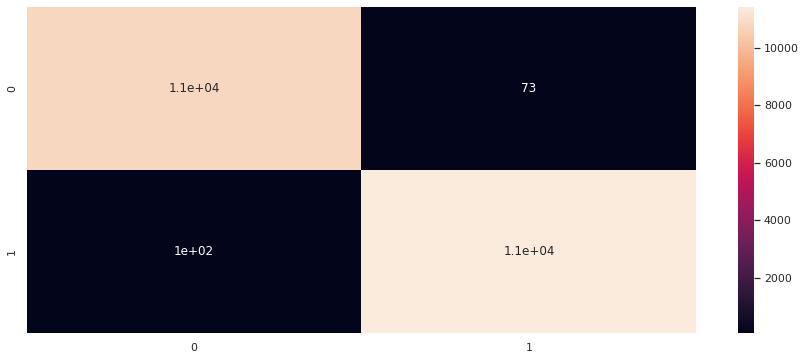

In [29]:
#SMOTE+ENN dataset
RFC_smenn=RandomForestClassifier(random_state=42)
RFC_smenn.fit(X_train_smenn,y_train_smenn)
RFC_pred_smenn=RFC_smenn.predict(X_test_smenn)
RFC_smenn_accuracy=accuracy_score(y_test_smenn, RFC_pred_smenn)
RFC_smenn_recall=recall_score(y_test_smenn, RFC_pred_smenn)
RFC_smenn_f1=f1_score(y_test_smenn, RFC_pred_smenn)
print(f'Accuracy = {RFC_smenn_accuracy:.4f}\nRecall = {RFC_smenn_recall:.4f}\nF1 score = {RFC_smenn_f1:.4f}')
cm = confusion_matrix(y_test_smenn, RFC_pred_smenn)
sns.heatmap(cm, annot=True)

In [58]:
#Collect Random Forest Classifier Result
RFC_ori_result=[RFC_ori_accuracy,RFC_ori_recall,RFC_ori_f1]
RFC_sm_result=[RFC_sm_accuracy,RFC_sm_recall,RFC_sm_f1]
RFC_smenn_result=[RFC_smenn_accuracy,RFC_smenn_recall,RFC_smenn_f1]

##KNN

Accuracy = 0.9858
Recall = 0.0000
F1 score = 0.0000


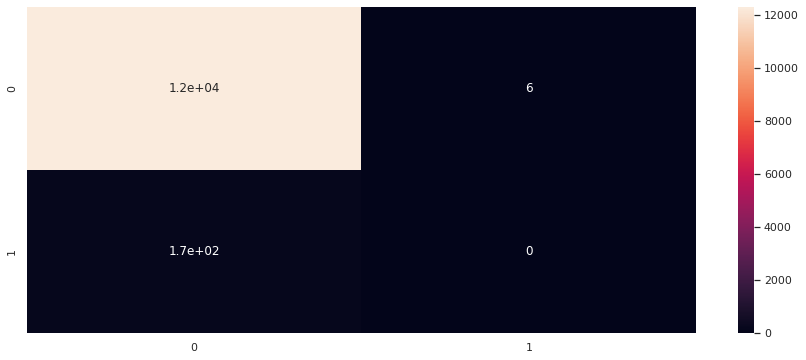

In [31]:
#Original dataset
KNN=KNeighborsClassifier()
KNN.fit(X_train_ori,y_train)
KNN_pred_ori=KNN.predict(X_test_ori)
KNN_ori_accuracy=accuracy_score(y_test, KNN_pred_ori)
KNN_ori_recall=recall_score(y_test, KNN_pred_ori)
KNN_ori_f1=f1_score(y_test, KNN_pred_ori)
print(f'Accuracy = {KNN_ori_accuracy:.4f}\nRecall = {KNN_ori_recall:.4f}\nF1 score = {KNN_ori_f1:.4f}')
cm = confusion_matrix(y_test, KNN_pred_ori)
sns.heatmap(cm, annot=True)

Accuracy = 0.9352
Recall = 0.9768
F1 score = 0.9369


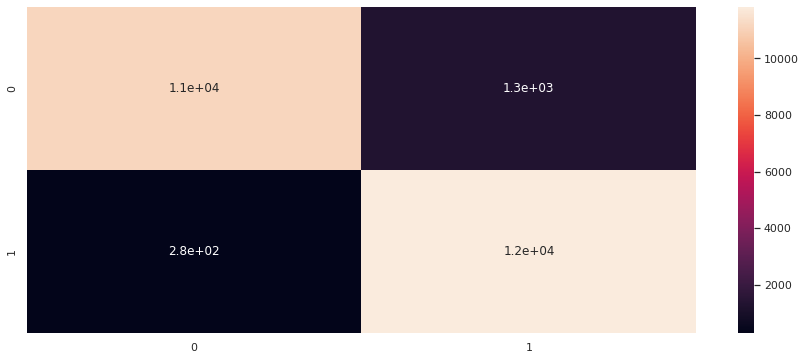

In [32]:
#SMOTE dataset
KNN_sm=KNeighborsClassifier()
KNN_sm.fit(X_train_sm,y_train_sm)
KNN_pred_sm=KNN_sm.predict(X_test_sm)
KNN_sm_accuracy=accuracy_score(y_test_sm, KNN_pred_sm)
KNN_sm_recall=recall_score(y_test_sm, KNN_pred_sm)
KNN_sm_f1=f1_score(y_test_sm, KNN_pred_sm)
print(f'Accuracy = {KNN_sm_accuracy:.4f}\nRecall = {KNN_sm_recall:.4f}\nF1 score = {KNN_sm_f1:.4f}')
cm = confusion_matrix(y_test_sm, KNN_pred_sm)
sns.heatmap(cm, annot=True)

Accuracy = 0.9692
Recall = 0.9921
F1 score = 0.9707


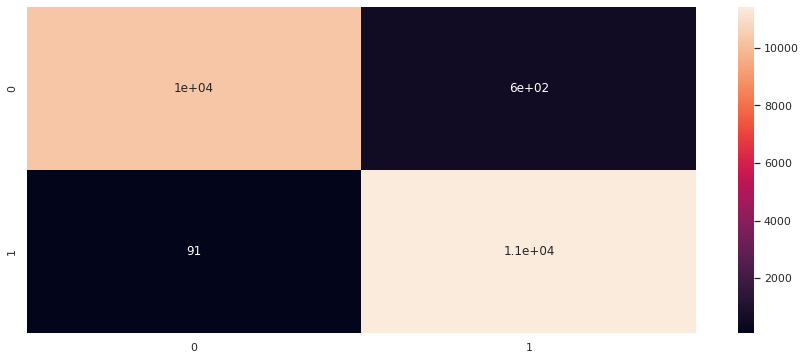

In [33]:
#SMOTE_ENN dataset
KNN_smenn=KNeighborsClassifier()
KNN_smenn.fit(X_train_smenn,y_train_smenn)
KNN_pred_smenn=KNN_smenn.predict(X_test_smenn)
KNN_smenn_accuracy=accuracy_score(y_test_smenn, KNN_pred_smenn)
KNN_smenn_recall=recall_score(y_test_smenn, KNN_pred_smenn)
KNN_smenn_f1=f1_score(y_test_smenn, KNN_pred_smenn)
print(f'Accuracy = {KNN_smenn_accuracy:.4f}\nRecall = {KNN_smenn_recall:.4f}\nF1 score = {KNN_smenn_f1:.4f}')
cm = confusion_matrix(y_test_smenn, KNN_pred_smenn)
sns.heatmap(cm, annot=True)

In [59]:
#Collect Naive Bayes Result
KNN_ori_result=[KNN_ori_accuracy,KNN_ori_recall,KNN_ori_f1]
KNN_sm_result=[KNN_sm_accuracy,KNN_sm_recall,KNN_sm_f1]
KNN_smenn_result=[KNN_smenn_accuracy,KNN_smenn_recall,KNN_smenn_f1]

##Naive Bayes

Accuracy = 0.9528
Recall = 0.2105
F1 score = 0.1091



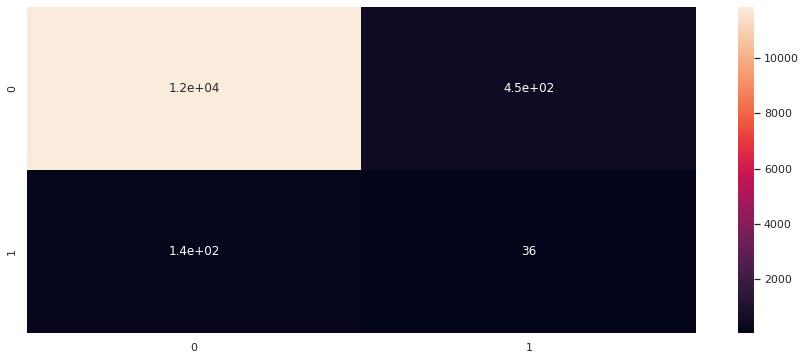

In [35]:
#Original dataset
NB=GaussianNB()
NB.fit(X_train_ori,y_train)
NB_pred_ori=NB.predict(X_test_ori)
NB_ori_accuracy=accuracy_score(y_test, NB_pred_ori)
NB_ori_recall=recall_score(y_test, NB_pred_ori)
NB_ori_f1=f1_score(y_test, NB_pred_ori)
print(f'Accuracy = {NB_ori_accuracy:.4f}\nRecall = {NB_ori_recall:.4f}\nF1 score = {NB_ori_f1:.4f}\n')
cm = confusion_matrix(y_test, NB_pred_ori)
sns.heatmap(cm, annot=True)

Accuracy = 0.7431
Recall = 0.6453
F1 score = 0.7121



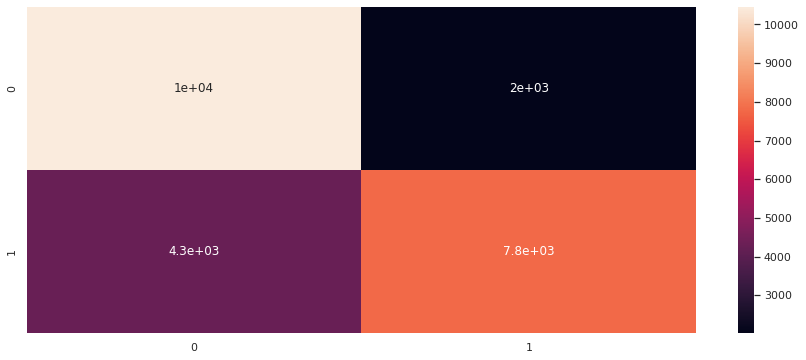

In [36]:
#SMOTE dataset
NB_sm=GaussianNB()
NB_sm.fit(X_train_sm,y_train_sm)
NB_pred_sm=NB_sm.predict(X_test_sm)
NB_sm_accuracy=accuracy_score(y_test_sm, NB_pred_sm)
NB_sm_recall=recall_score(y_test_sm, NB_pred_sm)
NB_sm_f1=f1_score(y_test_sm, NB_pred_sm)
print(f'Accuracy = {NB_sm_accuracy:.4f}\nRecall = {NB_sm_recall:.4f}\nF1 score = {NB_sm_f1:.4f}\n')
cm = confusion_matrix(y_test_sm, NB_pred_sm)
sns.heatmap(cm, annot=True)

Accuracy = 0.7605
Recall = 0.6592
F1 score = 0.7389



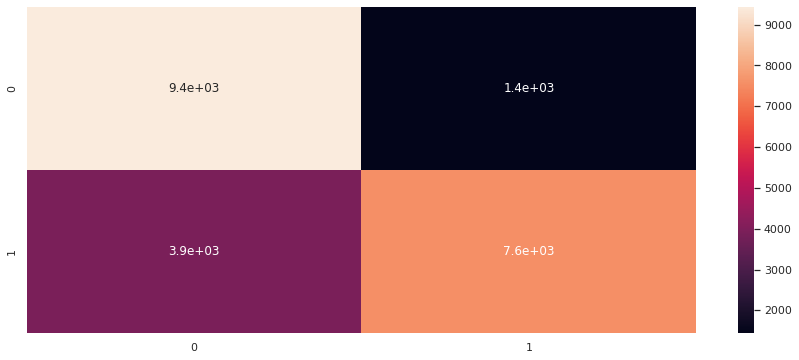

In [37]:
#SMOTE + ENN dataset
NB_smenn=GaussianNB()
NB_smenn.fit(X_train_smenn,y_train_smenn)
NB_pred_smenn=NB_smenn.predict(X_test_smenn)
NB_smenn_accuracy=accuracy_score(y_test_smenn, NB_pred_smenn)
NB_smenn_recall=recall_score(y_test_smenn, NB_pred_smenn)
NB_smenn_f1=f1_score(y_test_smenn, NB_pred_smenn)
print(f'Accuracy = {NB_smenn_accuracy:.4f}\nRecall = {NB_smenn_recall:.4f}\nF1 score = {NB_smenn_f1:.4f}\n')
cm = confusion_matrix(y_test_smenn, NB_pred_smenn)
sns.heatmap(cm, annot=True)

In [60]:
#Collect Naive Bayes Result
NB_ori_result=[NB_ori_accuracy,NB_ori_recall,NB_ori_f1]
NB_sm_result=[NB_sm_accuracy,NB_sm_recall,NB_sm_f1]
NB_smenn_result=[NB_smenn_accuracy,NB_smenn_recall,NB_smenn_f1]

##XGBoost

Accuracy = 0.9863
Recall = 0.0000
F1 score = 0.0000



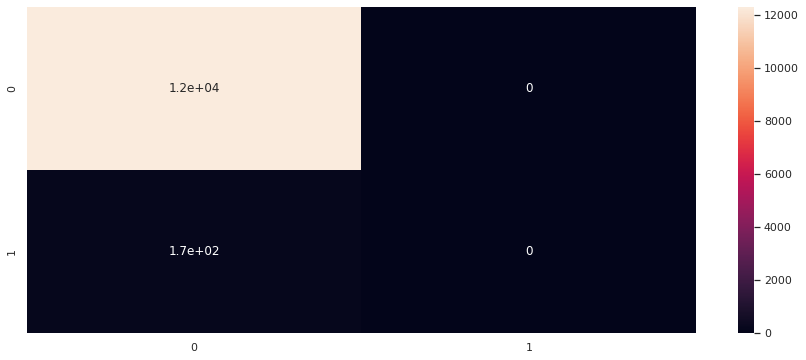

In [39]:
#Original dataset
XGB=XGBClassifier()
XGB.fit(X_train_ori,y_train)
XGB_pred_ori=XGB.predict(X_test_ori)
XGB_ori_accuracy=accuracy_score(y_test, XGB_pred_ori)
XGB_ori_recall=recall_score(y_test, XGB_pred_ori)
XGB_ori_f1=f1_score(y_test, XGB_pred_ori)
print(f'Accuracy = {XGB_ori_accuracy:.4f}\nRecall = {XGB_ori_recall:.4f}\nF1 score = {XGB_ori_f1:.4f}\n')
cm = confusion_matrix(y_test, XGB_pred_ori)
sns.heatmap(cm, annot=True)

Accuracy = 0.8629
Recall = 0.8560
F1 score = 0.8601



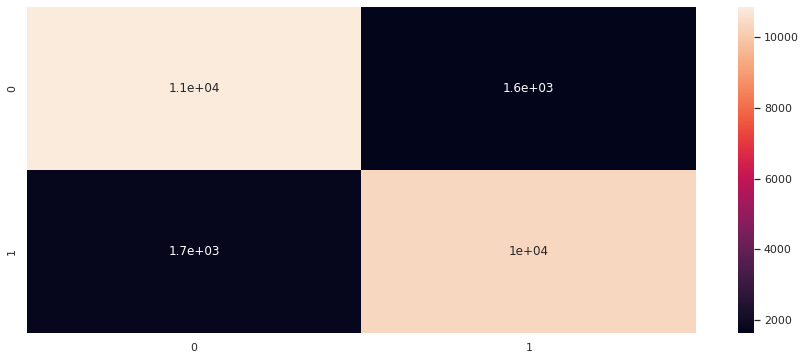

In [40]:
#SMOTE dataset
XGB_sm=XGBClassifier()
XGB_sm.fit(X_train_sm,y_train_sm)
XGB_pred_sm=XGB_sm.predict(X_test_sm)
XGB_sm_accuracy=accuracy_score(y_test_sm, XGB_pred_sm)
XGB_sm_recall=recall_score(y_test_sm, XGB_pred_sm)
XGB_sm_f1=f1_score(y_test_sm, XGB_pred_sm)
print(f'Accuracy = {XGB_sm_accuracy:.4f}\nRecall = {XGB_sm_recall:.4f}\nF1 score = {XGB_sm_f1:.4f}\n')
cm = confusion_matrix(y_test_sm, XGB_pred_sm)
sns.heatmap(cm, annot=True)

Accuracy = 0.8857
Recall = 0.8822
F1 score = 0.8881



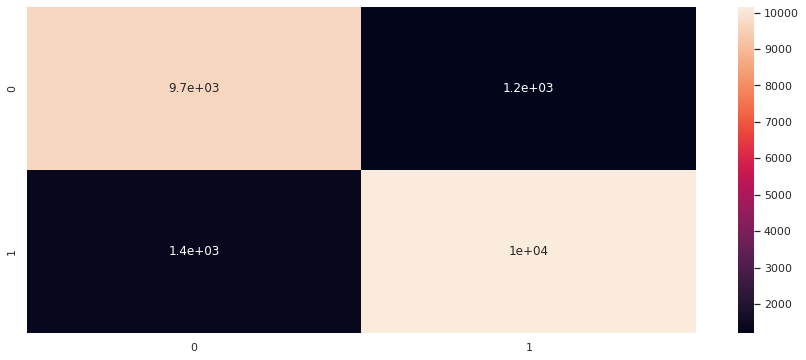

In [41]:
#SMOTE+ENN dataset
XGB_smenn=XGBClassifier()
XGB_smenn.fit(X_train_smenn,y_train_smenn)
XGB_pred_smenn=XGB_smenn.predict(X_test_smenn)
XGB_smenn_accuracy=accuracy_score(y_test_smenn, XGB_pred_smenn)
XGB_smenn_recall=recall_score(y_test_smenn, XGB_pred_smenn)
XGB_smenn_f1=f1_score(y_test_smenn, XGB_pred_smenn)
print(f'Accuracy = {XGB_smenn_accuracy:.4f}\nRecall = {XGB_smenn_recall:.4f}\nF1 score = {XGB_smenn_f1:.4f}\n')
cm = confusion_matrix(y_test_smenn, XGB_pred_smenn)
sns.heatmap(cm, annot=True)

In [61]:
#Collect XGB Result
XGB_ori_result=[XGB_ori_accuracy,XGB_ori_recall,XGB_ori_f1]
XGB_sm_result=[XGB_sm_accuracy,XGB_sm_recall,XGB_sm_f1]
XGB_smenn_result=[XGB_smenn_accuracy,XGB_smenn_recall,XGB_smenn_f1]

CatBoost

Learning rate set to 0.054687
0:	learn: 0.5750144	total: 59.8ms	remaining: 59.7s
1:	learn: 0.4835373	total: 71.7ms	remaining: 35.8s
2:	learn: 0.4055285	total: 83.4ms	remaining: 27.7s
3:	learn: 0.3471768	total: 94.9ms	remaining: 23.6s
4:	learn: 0.2956313	total: 107ms	remaining: 21.3s
5:	learn: 0.2554991	total: 117ms	remaining: 19.4s
6:	learn: 0.2220687	total: 128ms	remaining: 18.2s
7:	learn: 0.1941010	total: 140ms	remaining: 17.4s
8:	learn: 0.1722624	total: 152ms	remaining: 16.7s
9:	learn: 0.1548721	total: 164ms	remaining: 16.3s
10:	learn: 0.1405396	total: 174ms	remaining: 15.7s
11:	learn: 0.1281642	total: 186ms	remaining: 15.3s
12:	learn: 0.1181107	total: 202ms	remaining: 15.3s
13:	learn: 0.1101271	total: 214ms	remaining: 15.1s
14:	learn: 0.1036989	total: 227ms	remaining: 14.9s
15:	learn: 0.0979399	total: 240ms	remaining: 14.7s
16:	learn: 0.0932933	total: 253ms	remaining: 14.6s
17:	learn: 0.0894800	total: 266ms	remaining: 14.5s
18:	learn: 0.0863301	total: 276ms	remaining: 14.3s
19:	lea

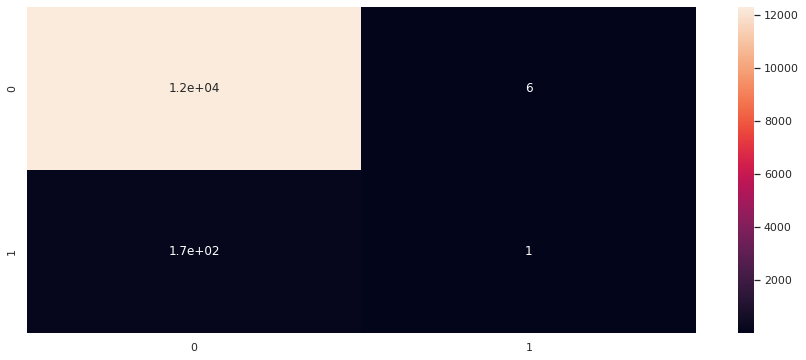

In [43]:
#Original dataset
CB=CatBoostClassifier()
CB.fit(X_train_ori,y_train)
CB_pred_ori=CB.predict(X_test_ori)
CB_ori_accuracy=accuracy_score(y_test, CB_pred_ori)
CB_ori_recall=recall_score(y_test, CB_pred_ori)
CB_ori_f1=f1_score(y_test, CB_pred_ori)
print(f'Accuracy = {CB_ori_accuracy:.4f}\nRecall = {CB_ori_recall:.4f}\nF1 score = {CB_ori_f1:.4f}\n')
cm = confusion_matrix(y_test, CB_pred_ori)
sns.heatmap(cm, annot=True)

Learning rate set to 0.073059
0:	learn: 0.6543140	total: 28.5ms	remaining: 28.4s
1:	learn: 0.6269637	total: 54.7ms	remaining: 27.3s
2:	learn: 0.5899212	total: 78.2ms	remaining: 26s
3:	learn: 0.5628197	total: 103ms	remaining: 25.7s
4:	learn: 0.5398515	total: 127ms	remaining: 25.4s
5:	learn: 0.5219151	total: 153ms	remaining: 25.3s
6:	learn: 0.5071516	total: 177ms	remaining: 25.1s
7:	learn: 0.4914347	total: 206ms	remaining: 25.5s
8:	learn: 0.4773464	total: 230ms	remaining: 25.4s
9:	learn: 0.4670671	total: 254ms	remaining: 25.1s
10:	learn: 0.4578106	total: 278ms	remaining: 25s
11:	learn: 0.4515256	total: 301ms	remaining: 24.8s
12:	learn: 0.4450956	total: 329ms	remaining: 25s
13:	learn: 0.4367626	total: 353ms	remaining: 24.8s
14:	learn: 0.4314110	total: 377ms	remaining: 24.8s
15:	learn: 0.4249186	total: 401ms	remaining: 24.7s
16:	learn: 0.4171973	total: 430ms	remaining: 24.9s
17:	learn: 0.4137920	total: 454ms	remaining: 24.7s
18:	learn: 0.4104114	total: 478ms	remaining: 24.7s
19:	learn: 0.4

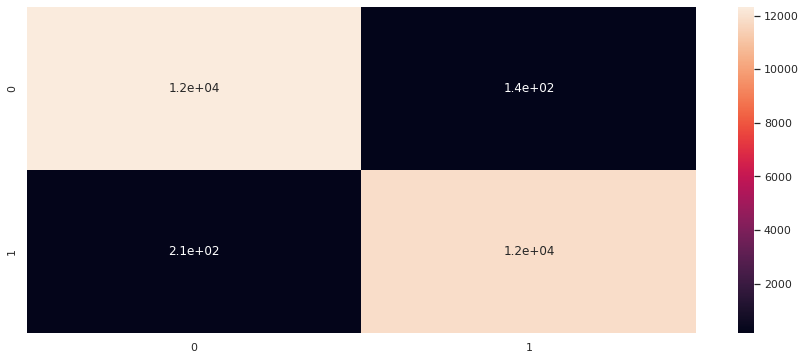

In [44]:
#SMOTE dataset
CB_sm=CatBoostClassifier()
CB_sm.fit(X_train_sm,y_train_sm)
CB_pred_sm=CB_sm.predict(X_test_sm)
CB_sm_accuracy=accuracy_score(y_test_sm, CB_pred_sm)
CB_sm_recall=recall_score(y_test_sm, CB_pred_sm)
CB_sm_f1=f1_score(y_test_sm, CB_pred_sm)
print(f'Accuracy = {CB_sm_accuracy:.4f}\nRecall = {CB_sm_recall:.4f}\nF1 score = {CB_sm_f1:.4f}\n')
cm = confusion_matrix(y_test_sm, CB_pred_sm)
sns.heatmap(cm, annot=True)

Learning rate set to 0.070199
0:	learn: 0.6453458	total: 24.1ms	remaining: 24.1s
1:	learn: 0.6069680	total: 46.9ms	remaining: 23.4s
2:	learn: 0.5702377	total: 68.9ms	remaining: 22.9s
3:	learn: 0.5447639	total: 90.2ms	remaining: 22.4s
4:	learn: 0.5167849	total: 112ms	remaining: 22.3s
5:	learn: 0.4918076	total: 138ms	remaining: 22.8s
6:	learn: 0.4749943	total: 159ms	remaining: 22.6s
7:	learn: 0.4554080	total: 182ms	remaining: 22.6s
8:	learn: 0.4429595	total: 213ms	remaining: 23.4s
9:	learn: 0.4321074	total: 236ms	remaining: 23.3s
10:	learn: 0.4185416	total: 259ms	remaining: 23.2s
11:	learn: 0.4107041	total: 281ms	remaining: 23.1s
12:	learn: 0.4033018	total: 302ms	remaining: 22.9s
13:	learn: 0.3952205	total: 324ms	remaining: 22.8s
14:	learn: 0.3877208	total: 346ms	remaining: 22.7s
15:	learn: 0.3828639	total: 367ms	remaining: 22.6s
16:	learn: 0.3786887	total: 388ms	remaining: 22.4s
17:	learn: 0.3746716	total: 420ms	remaining: 22.9s
18:	learn: 0.3682336	total: 443ms	remaining: 22.9s
19:	lea

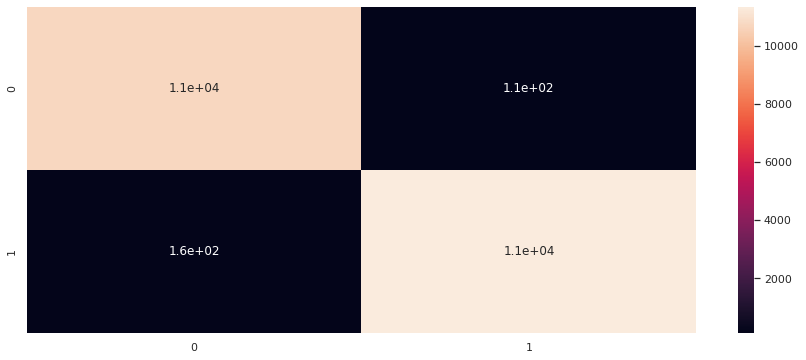

In [45]:
#SMOTE + ENN dataset
CB_smenn=CatBoostClassifier()
CB_smenn.fit(X_train_smenn,y_train_smenn)
CB_pred_smenn=CB_smenn.predict(X_test_smenn)
CB_smenn_accuracy=accuracy_score(y_test_smenn, CB_pred_smenn)
CB_smenn_recall=recall_score(y_test_smenn, CB_pred_smenn)
CB_smenn_f1=f1_score(y_test_smenn, CB_pred_smenn)
print(f'Accuracy = {CB_smenn_accuracy:.4f}\nRecall = {CB_smenn_recall:.4f}\nF1 score = {CB_smenn_f1:.4f}\n')
cm = confusion_matrix(y_test_smenn, CB_pred_smenn)
sns.heatmap(cm, annot=True)

In [62]:
#Collect CB Result
CB_ori_result=[CB_ori_accuracy,CB_ori_recall,CB_ori_f1]
CB_sm_result=[CB_sm_accuracy,CB_sm_recall,CB_sm_f1]
CB_smenn_result=[CB_smenn_accuracy,CB_smenn_recall,CB_smenn_f1]

#Model Selection

##Tabluate the result according to metrics

In [64]:
#Create the label
x_label=['Logistic Regression','Random Forest Classifier','KNN','Naive Bayes','XGBoost','Cat Boost']
y_label=['Original','SMOTE','SMOTE+ENN']

#Combine the result
original_result=LR_ori_result+RFC_ori_result+KNN_ori_result+NB_ori_result+XGB_ori_result+CB_ori_result
sm_result=LR_sm_result+RFC_sm_result+KNN_sm_result+NB_sm_result+XGB_sm_result+CB_sm_result
smenn_result=LR_smenn_result+RFC_smenn_result+KNN_smenn_result+NB_smenn_result+XGB_smenn_result+CB_smenn_result

df_result = pd.DataFrame([original_result,sm_result,smenn_result],
                  index=pd.Index(y_label, name='Resampling'),
                  columns=pd.MultiIndex.from_product([x_label,['Accuracy', 'Recall','F1 score']], names=['Model:', 'Metrics:']))
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#F2EDF4')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #8B2CC3; color: white;'
}
s = df_result.style
s.set_table_styles([cell_hover, index_names, headers])
s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},
    {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
], overwrite=False)
s.set_table_styles({('Random Forest Classifier', 'Accuracy'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},{'selector': 'td', 'props': 'border-left: 1px solid #8B2CC3'}]}, overwrite=False, axis=0)
s.set_table_styles({('KNN', 'Accuracy'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},{'selector': 'td', 'props': 'border-left: 1px solid #8B2CC3'}]}, overwrite=False, axis=0)
s.set_table_styles({('Naive Bayes', 'Accuracy'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},{'selector': 'td', 'props': 'border-left: 1px solid #8B2CC3'}]}, overwrite=False, axis=0)
s.set_table_styles({('XGBoost', 'Accuracy'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},{'selector': 'td', 'props': 'border-left: 1px solid #8B2CC3'}]}, overwrite=False, axis=0)
s.set_table_styles({('Cat Boost', 'Accuracy'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},{'selector': 'td', 'props': 'border-left: 1px solid #8B2CC3#8B2CC3'}]}, overwrite=False, axis=0)


#####Random Forest Classifier provide the best Accuracy, Recall & F1 score using SMOTE+ENN resampling method

##Hyperparameter tunning for Random Forest Classifier

##Randomized Search CV

In [67]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 15, num = 5)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [5, 7, 10, 12, 15], 'max_features': ['log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [68]:
#Model training for Randomized Search CV
rand_classifier = RandomForestClassifier()
RFC_random = RandomizedSearchCV(estimator = rand_classifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
RFC_random.fit(X_train_smenn,y_train_smenn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 7, 10, 12, 15]},
                   random_state=42, verbose=2)

In [69]:
#Print the best parameters from Randomized Search CV
RFC_random.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15}

Accuracy = 0.9924
Recall = 0.9910
F1 score = 0.9926



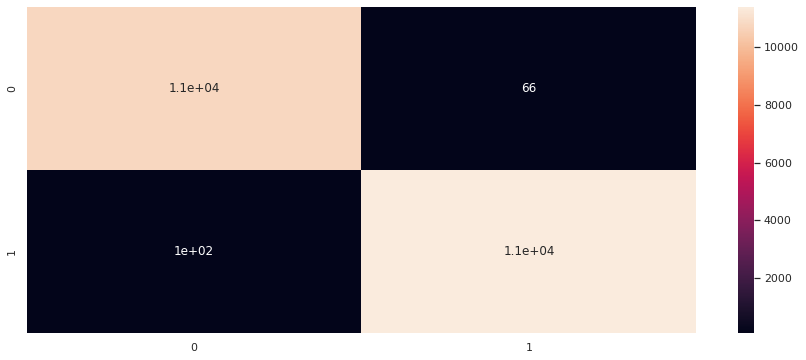

In [70]:
#Make prediction
best_random = RFC_random.best_estimator_
y_pred_rand=best_random.predict(X_test_smenn)
rand_accuracy=accuracy_score(y_test_smenn, y_pred_rand)
rand_recall=recall_score(y_test_smenn, y_pred_rand)
rand_f1=f1_score(y_test_smenn, y_pred_rand)
print(f'Accuracy = {rand_accuracy:.4f}\nRecall = {rand_recall:.4f}\nF1 score = {rand_f1:.4f}\n')
cm = confusion_matrix(y_test_smenn, y_pred_rand)
sns.heatmap(cm, annot=True)

##Grid Search CV

In [73]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [30,50,70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [15,20,25]
}

#Train the model
grid_classifier = RandomForestClassifier()
RFC_grid = GridSearchCV(estimator = grid_classifier, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
RFC_grid.fit(X_train_smenn,y_train_smenn)
RFC_grid.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 25}

Accuracy = 0.9925
Recall = 0.9911
F1 score = 0.9927



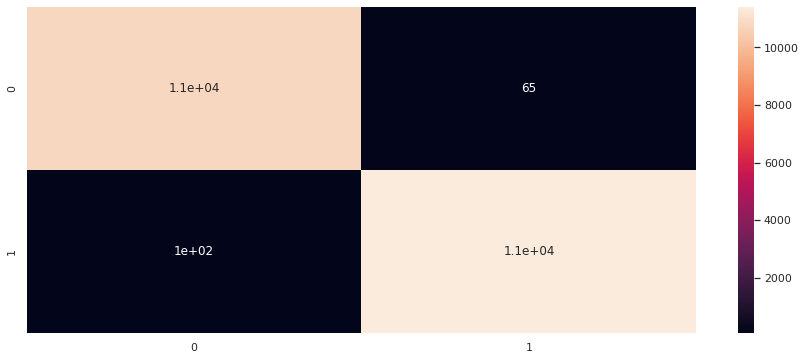

In [76]:
#Make prediction
best_grid = RFC_grid.best_estimator_
y_pred_grid=best_grid.predict(X_test_smenn)
grid_accuracy=accuracy_score(y_test_smenn, y_pred_grid)
grid_recall=recall_score(y_test_smenn, y_pred_grid)
grid_f1=f1_score(y_test_smenn, y_pred_grid)
print(f'Accuracy = {grid_accuracy:.4f}\nRecall = {grid_recall:.4f}\nF1 score = {grid_f1:.4f}\n')
cm = confusion_matrix(y_test_smenn, y_pred_grid)
sns.heatmap(cm, annot=True)

In [85]:
x_labels = ["Base_model", "Best_Random", "Best_Grid"]
y_labels=["Accuracy","Recall","F1 score"]
accuracy = [RFC_smenn_accuracy,rand_accuracy,grid_accuracy]
recall = [RFC_smenn_recall,rand_recall,grid_recall]
f1_score = [RFC_smenn_f1,rand_f1,grid_f1]

df_best = pd.DataFrame([accuracy,recall,f1_score],
                  index=pd.Index(y_labels, name='Metric'),
                  columns=pd.Index(x_labels, name='Model'))

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#F2EDF4')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #8B2CC3; color: white;'
}
r = df_best.style
r.set_table_styles([cell_hover, index_names, headers])
r.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},
    {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
], overwrite=False)
r.set_table_styles({('Best_Random'): [{'selector': 'th', 'props': 'border-left: 1px solid white'}]}, overwrite=False, axis=0)
r.set_table_styles({('Best_Grid'): [{'selector': 'th', 'props': 'border-left: 1px solid white'}]}, overwrite=False, axis=0)

Model,Base_model,Best_Random,Best_Grid
Metric,,,
Accuracy,0.992178,0.992401,0.992535
Recall,0.991134,0.990960,0.991134
F1 score,0.992384,0.992599,0.992730
